In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LRModel") \
    .enableHiveSupport() \
    .getOrCreate()

In [2]:
! python3 -m pip install scikit-learn

  Using cached https://files.pythonhosted.org/packages/f5/ef/bcd79e8d59250d6e8478eb1290dc6e05be42b3be8a86e3954146adbc171a/scikit_learn-0.24.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7c/91/d3ba0401e62d7e42816bc7d97b82d19c95c164b3e149a87c0a1c026a735e/joblib-1.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
#from pyspark.sql.functions import pandas_udf
#from pyspark.sql.types import IntegerType

In [4]:
#  Define the Hive table name
hive_table = "flight_db.flight_data_partitioned_month"

#  Read the Hive table into a Spark DataFrame
df_spark = spark.sql(f"SELECT * FROM {hive_table}")

In [5]:
# Get the unique months available in the data
months = df_spark.select("Month").distinct().collect()
print(months)
# Sample 5% data for each month
df_monthly_sampled = None

for month in months:
    month_data = df_spark.filter(df_spark.Month == month["Month"]) \
                         .sample(withReplacement=False, fraction=0.05, seed=1234)
    
    # Union the monthly sampled data
    if df_monthly_sampled is None:
        df_monthly_sampled = month_data
    else:
        df_monthly_sampled = df_monthly_sampled.union(month_data)

# Show the first 5 rows of the sampled data
df_monthly_sampled.show(5)

[Row(Month='7'), Row(Month='11'), Row(Month='3'), Row(Month='8'), Row(Month='5'), Row(Month='6'), Row(Month='9'), Row(Month='1'), Row(Month='10'), Row(Month='4'), Row(Month='12'), Row(Month='2')]
+----+-------+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+---------------+------------------+------------------+------+---------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+---------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+--------+--------------+-----------------+----

In [6]:
df=df_monthly_sampled.toPandas()

In [7]:
# Select relevant features
features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
target = 'DepDel15'  # Binary classification (1 = delay >= 15 min, 0 = no delay)


In [8]:
# Separate features and target variable
X = df[features]
y = df[target].astype(int)  # Ensure binary classification

In [9]:
# Identify numerical and categorical features
num_features = ['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
cat_features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest']

In [10]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [11]:
# Create pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 500))
])

In [12]:
param_grid = {
    'classifier__C': np.logspace(-4, 4, 10),  # Wider range of regularization strengths
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for different dataset sizes
    'classifier__class_weight': ['balanced', None],  # Handle imbalanced data
    'classifier__penalty': ['l1', 'l2']  # Regularization type (liblinear: l1, l2; saga: l1, l2)
}


In [13]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [14]:
# Perform  Randomized grid search
random_search = RandomizedSearchCV(estimator=pipeline,param_distributions=param_grid, cv=5, n_jobs=-1, scoring = 'recall')

In [15]:
random_search.fit(X_train, y_train)
# Print best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': 'balanced', 'classifier__C': 0.005994842503189409}


In [16]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [17]:
# Model evaluation

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9393
Precision: 0.8722
Recall: 0.7867
F1-score: 0.8272


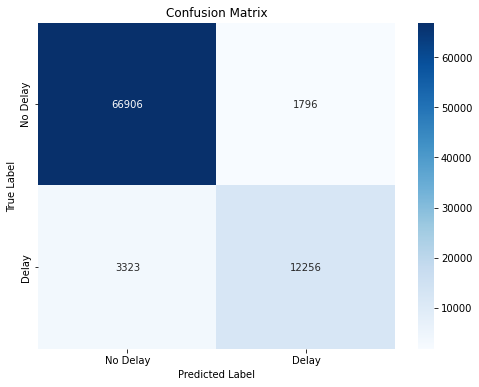

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
report = classification_report(y_test, y_pred)

print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     68702
           1       0.87      0.79      0.83     15579

    accuracy                           0.94     84281
   macro avg       0.91      0.88      0.90     84281
weighted avg       0.94      0.94      0.94     84281



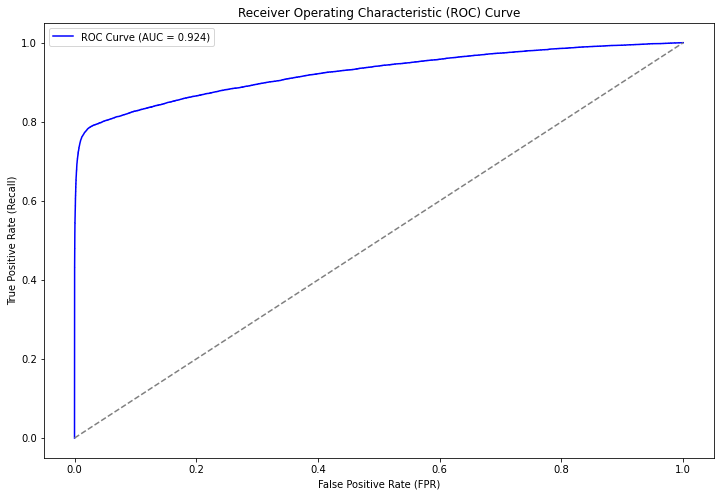

AUC Score: 0.924


In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities (positive class)
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC Score
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.3f}")

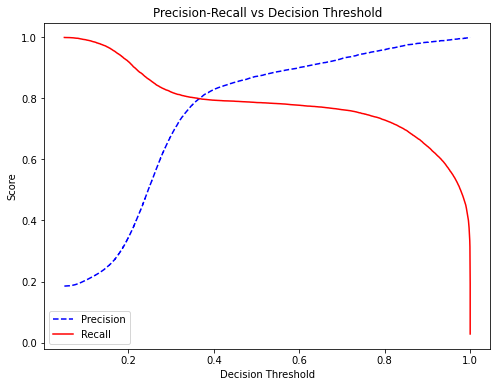

In [21]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute Precision-Recall values for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Decision Threshold")
plt.show()

In [23]:
# DEFAULT THRESHOLD IS 0.5
new_threshold = 0.37
y_pred_new = (y_probs >= new_threshold).astype(int)

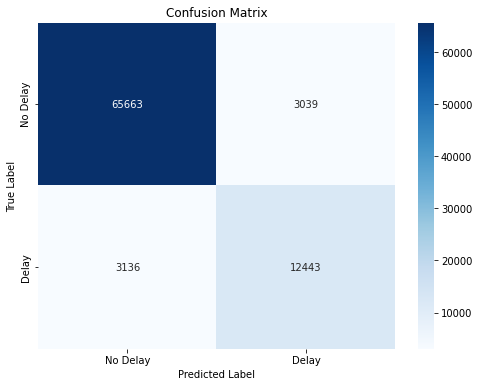

In [24]:
cm = confusion_matrix(y_test, y_pred_new)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     68702
           1       0.80      0.80      0.80     15579

    accuracy                           0.93     84281
   macro avg       0.88      0.88      0.88     84281
weighted avg       0.93      0.93      0.93     84281



In [26]:
import pickle
with open('logistic_rs_model.pkl','wb') as f:
    pickle.dump(random_search,f)
    